In [5]:
from utils import *
from load_from_dropbox import *

In [2]:
dbx = dropbox_connect()
hf = download_h5_file(dbx, '/fastMRI_data_h5_flair/file_brain_AXFLAIR_201_6003018.h5')
print(list(hf.keys()))
print(list(hf.attrs))
volume_kspace = hf['kspace'][()]
volume_img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(volume_kspace), norm='ortho'))
print(volume_img.shape)

['ismrmrd_header', 'kspace', 'reconstruction_rss']
['acquisition', 'max', 'norm', 'patient_id']
(16, 16, 640, 320)


In [3]:
dbx = dropbox_connect()
flair_motion = load_npy_from_dropbox(dbx, '/Motion_data_whole_notrans_flair_0922')
print(f"Loaded {len(flair_motion)} npy files.") #163

Loaded 163 npy files.


In [4]:
dbx = dropbox_connect()
flair_clear_h5 = load_h5_from_dropbox(dbx, '/fastMRI_data_h5_flair', max_workers=24)
print(f"Loaded {len(flair_clear_h5)} h5 files.") #163

Loaded 163 h5 files.


In [5]:
flair_clear = {}
for subject_id, hf in flair_clear_h5.items():
    volume = hf['kspace'][()]
    volume = rss_coil_combine(ifft2c(volume))
    flair_clear[subject_id] = volume
print(len(flair_clear))

163


In [6]:
dbx = dropbox_connect()
t2_motion = load_npy_from_dropbox(dbx, '/Motion_data_whole_notrans_t2_0922', max_workers=24)
print(f"Loaded {len(t2_motion)} npy files.") #165

Loaded 165 npy files.


In [7]:
dbx = dropbox_connect()
t2_clear = load_npy_from_dropbox(dbx, '/Clear_data_notrans_t2_0922', max_workers=24)
print(f"Loaded {len(t2_clear)} npy files.") #164
# 2010565 is missing dropbox에서 없어졋어;

Loaded 164 npy files.


In [8]:
dbx = dropbox_connect()
t1post_motion = load_npy_from_dropbox(dbx, '/Motion_data_whole_notrans_t1post_0922', max_workers=24)
print(f"Loaded {len(t1post_motion)} npy files.") #199

Loaded 199 npy files.


In [9]:
dbx = dropbox_connect()
t1post_clear = load_npy_from_dropbox(dbx, '/Clear_data_notrans_t1post_0922', max_workers=24)
print(f"Loaded {len(t1post_clear)} npy files.") #199

Loaded 199 npy files.


# Metric

In [10]:
from skimage.metrics import structural_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk

### SSIM

In [15]:
"""
Reference : Similarity Metrics for MR Image-to-Image Translation
https://arxiv.org/pdf/2405.08431
"""

def calculate_ssim(clear_dict, motion_dict):
    results = []

    for key in clear_dict:
        if key in motion_dict:
            data_ref = clear_dict[key]
            data_img = motion_dict[key]
            crop_size = data_ref.shape[-1]
            data_ref = crop(data_ref, crop_size)
            data_img = crop(data_img, crop_size)

            for slice_idx in range(data_ref.shape[0]):
                ref_Z = Znormalization(data_ref[slice_idx])
                img_Z = Znormalization(data_img[slice_idx])
                ref_minmax = minmax_normalization(data_ref[slice_idx])
                img_minmax = minmax_normalization(data_img[slice_idx])
                data_range1 = max(ref_Z.max(), img_Z.max()) - min(ref_Z.min(), img_Z.min())
                data_range2 = max(ref_minmax.max(), img_minmax.max()) - min(ref_minmax.min(), img_minmax.min())
                ssim_value_Z = structural_similarity(img_Z, ref_Z, data_range=data_range1, gaussian_weights=True)
                ssim_value_minmax = structural_similarity(img_minmax, ref_minmax, data_range=data_range2, gaussian_weights=True)
                results.append({
                    'Subject ID': key,
                    'Slice Index': slice_idx,
                    'SSIM_Zscore': ssim_value_Z,
                    'SSIM_minmax': ssim_value_minmax
                    })

    df = pd.DataFrame(results)
    return df

In [29]:
df_flair = calculate_ssim(flair_clear, flair_motion)
df_t2 = calculate_ssim(t2_clear, t2_motion)
df_t1post = calculate_ssim(t1post_clear, t1post_motion)

In [ ]:
# df_flair.to_csv('flair_SSIM.csv', index=False)
# df_t2.to_csv('t2_SSIM.csv', index=False)
# df_t1post.to_csv('t1post_SSIM.csv', index=False)

### motion

parameter 2d 기준
[translation y방향, translation x방향, 0, rotation yaw, 0,0]

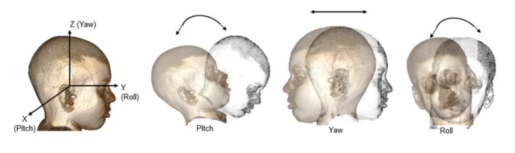

In [46]:
if __name__ == "__main__":
    dbx = dropbox_connect()
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_flair_0922'
    flair_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(flair_clear_h5)} npy files.") #163
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_t2_0922'
    t2_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(t2_motion_param)} npy files.") #165
    dropbox_folder_path = '/MotionParam_apply_whole_notrans_t1post_0922'
    t1_motion_param = load_npy_from_dropbox(dbx, dropbox_folder_path, data_type = 'param')
    print(f"Loaded {len(t1_motion_param)} npy files.") #199

Loaded 163 npy files.
Loaded 165 npy files.
Loaded 199 npy files.


In [48]:
def plot_motion_parameters(motion_parameters):
    translation = motion_parameters[:, :3]  
    rotation = motion_parameters[:, 3:]    
    time = np.arange(motion_parameters.shape[0])  
    translation_norm = np.linalg.norm(translation, axis=1)
    rotation_norm = np.linalg.norm(rotation, axis=1)

    plt.figure(figsize=(12, 16))

    plt.subplot(4, 1, 1)
    plt.plot(time, translation[:, 0], label='Translation X')
    plt.plot(time, translation[:, 1], label='Translation Y')
    plt.plot(time, translation[:, 2], label='Translation Z')
    plt.xlabel('Time (frames)')
    plt.ylabel('Translation (mm)')
    plt.title('Translation Parameters Over Time')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(time, rotation[:, 0], label='Rotation X (pitch)')
    plt.plot(time, rotation[:, 1], label='Rotation Y (yaw)')
    plt.plot(time, rotation[:, 2], label='Rotation Z (roll)')
    plt.xlabel('Time (frames)')
    plt.ylabel('Rotation (degrees or radians)')
    plt.title('Rotation Parameters Over Time')
    plt.legend()

    # Translation Norm Plot
    plt.subplot(4, 1, 3)
    plt.plot(time, translation_norm, label='Translation Norm', color='b')
    plt.xlabel('Time (frames)')
    plt.ylabel('Translation (mm)')
    plt.title('Translation Norm Over Time')
    plt.legend()

    # Rotation Norm Plot
    plt.subplot(4, 1, 4)
    plt.plot(time, rotation_norm, label='Rotation Norm', color='r')
    plt.xlabel('Time (frames)')
    plt.ylabel('Rotation (degrees or radians)')
    plt.title('Rotation Norm Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_motion_parameters(param_dict):
    results = []
    for key in param_dict:
        motion_parameters = param_dict[key]
        translation = motion_parameters[:, :3]  
        rotation = motion_parameters[:, 3:]  
        displacement_rms = np.sqrt(np.mean(np.power(translation, 2)))
        rotation_rms = np.sqrt(np.mean(np.power(rotation, 2)))
        motion = np.sqrt(np.power(np.asarray(rotation_rms), 2) + np.power(np.asarray(displacement_rms), 2))
        results.append({
            'Subject ID': key,
            'displacement_rms' : displacement_rms,
            'rotation_rms': rotation_rms,
            'motion': motion
            })
        
    df = pd.DataFrame(results)
    return df

In [49]:
df_flair_param = calculate_motion_parameters(flair_motion_param)
df_t2_param = calculate_motion_parameters(t2_motion_param)
df_t1_param = calculate_motion_parameters(t1_motion_param)

# df_flair_param.to_csv('flair_motion.csv', index=False)
# df_t2_param.to_csv('t2_motion.csv', index=False)
# df_t1_param.to_csv('t1_motion.csv', index=False)

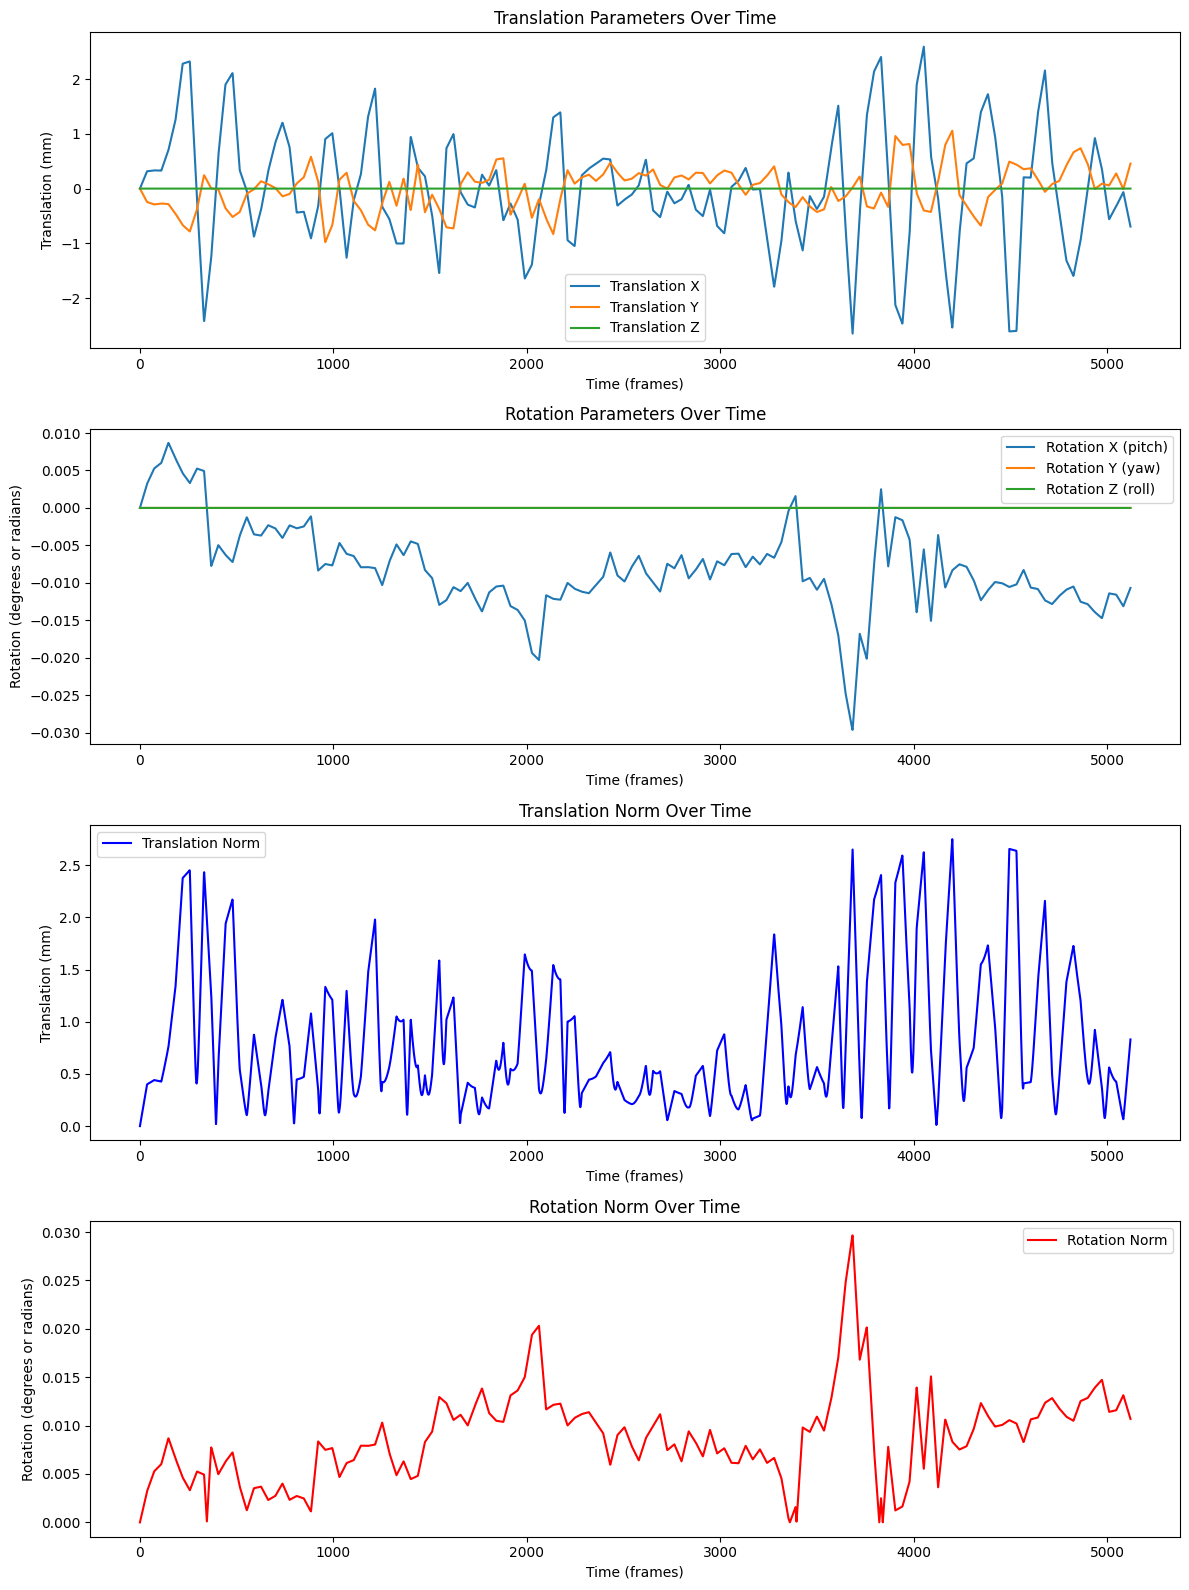

In [51]:
first_motion_param = list(flair_motion_param.values())[0]
plot_motion_parameters(first_motion_param)

## No reference metric

In [16]:
"""
Reference : Similarity Metrics for MR Image-to-Image Translation
https://arxiv.org/pdf/2405.08431
"""

from skimage.measure import blur_effect

def pearson_correlation(I, R):
    mean_I = np.mean(I)
    mean_R = np.mean(R)
    
    covariance = np.sum((I - mean_I) * (R - mean_R))
    standard_deviation_I = np.sqrt(np.sum((I - mean_I) ** 2))
    standard_deviation_R = np.sqrt(np.sum((R - mean_R) ** 2))
    
    pcc = covariance / (standard_deviation_I * standard_deviation_R)
    return pcc

def calculate_mlc(image):
    h, w = image.shape
    mlc_horizontal = np.mean([pearson_correlation(image[:, x], image[:, x+1]) for x in range(w-1)])
    mlc_vertical = np.mean([pearson_correlation(image[y, :], image[y+1, :]) for y in range(h-1)])
    return mlc_horizontal + mlc_vertical

def calculate_mslc(image):
    h, w = image.shape
    half_w, half_h = w // 2, h // 2
    mslc_horizontal = np.mean([pearson_correlation(image[:, x], image[:, x + half_w]) for x in range(w - half_w)])
    mslc_vertical = np.mean([pearson_correlation(image[y, :], image[y + half_h]) for y in range(h - half_h)])
    return mslc_horizontal + mslc_vertical

In [17]:
def calculate_NR_metrics(dict):
    results = []
    for key in dict:
        img = dict[key]
        img = crop(img, img.shape[-1])
        for slice_idx in range(img.shape[0]):
            Z = Znormalization(img[slice_idx])
            minmax = minmax_normalization(img[slice_idx])
            BLUR_Z = blur_effect(Z)
            BLUR_minmax = blur_effect(minmax)
            MLC_Z = calculate_mlc(Z)
            MSLC_Z = calculate_mslc(Z)
            MLC_minmax = calculate_mlc(minmax)
            MSLC_minmax = calculate_mslc(minmax)

            results.append({
                'Subject ID': key,
                'Slice Index': slice_idx,
                'BLUR_Z': BLUR_Z,  
                'MLC_Z': MLC_Z,
                'MSLC_Z': MSLC_Z,
                'BLUR_minmax': BLUR_minmax,
                'MLC_minmax': MLC_minmax,
                'MSLC_minmax': MSLC_minmax
                })

    df = pd.DataFrame(results)
    return df

In [18]:
flair_clear_NR_df = calculate_NR_metrics(flair_clear)
flair_motion_NR_df = calculate_NR_metrics(flair_motion)
t2_clear_NR_df = calculate_NR_metrics(t2_clear)
t2_motion_NR_df = calculate_NR_metrics(t2_motion)
t1post_clear_NR_df = calculate_NR_metrics(t1post_clear)
t1post_motion_NR_df = calculate_NR_metrics(t1post_motion)

In [19]:
flair_clear_NR_df.to_csv('flair_clear_NR.csv', index=False)
flair_motion_NR_df.to_csv('flair_motion_NR.csv', index=False)
t2_clear_NR_df.to_csv('t2_clear_NR.csv', index=False)
t2_motion_NR_df.to_csv('t2_motion_NR.csv', index=False)
t1post_clear_NR_df.to_csv('t1post_clear_NR.csv', index=False)
t1post_motion_NR_df.to_csv('t1post_motion_NR.csv', index=False)

# Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import SimpleITK as sitk
import numpy as np
from ipywidgets import interact
from skimage.transform import rotate
from tqdm.notebook import tqdm

In [3]:
def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):

  assert arr_after.shape == arr_before.shape

  def fn(SLICE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap, origin='lower')

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap, origin='lower')

    plt.tight_layout()

  interact(fn, SLICE=(0, arr_before.shape[0]-1))

In [20]:
def process_dict(data_dict, output_dir):
    os.makedirs(output_dir, exist_ok=True) 
    for key, volume in tqdm(data_dict.items(), desc="Processing volumes"):
        volume = correct_bias_field(volume)
        volume = crop(padding(volume, 396), 396)
        for i in range(volume.shape[0]): 
            volume[i, :, :] = Znormalization(volume[i, :, :])
        file_path = os.path.join(output_dir, f"{key}.npy")
        np.save(file_path, volume)
        data_dict[key] = volume
    return data_dict

In [21]:
flair_motion = process_dict(flair_motion, '/root/Data/flair_motion')
flair_clear = process_dict(flair_clear, '/root/Data/flair_clear')

Processing volumes:   0%|          | 0/163 [00:00<?, ?it/s]

Processing volumes:   0%|          | 0/163 [00:00<?, ?it/s]

In [22]:
t2_motion = process_dict(t2_motion, '/root/Data/t2_motion')
t2_clear = process_dict(t2_clear, '/root/Data/t2_clear')

Processing volumes:   0%|          | 0/165 [00:00<?, ?it/s]

Processing volumes:   0%|          | 0/164 [00:00<?, ?it/s]

In [23]:
t1post_motion = process_dict(t1post_motion, '/root/Data/t1post_motion')
t1post_clear = process_dict(t1post_clear, '/root/Data/t1post_clear')

Processing volumes:   0%|          | 0/199 [00:00<?, ?it/s]

Processing volumes:   0%|          | 0/199 [00:00<?, ?it/s]

In [24]:
def plot_volume(mr_data, output_folder):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for subject_id, volume in mr_data.items():
        num_slices = 8
        plt.figure(figsize=(40, 20))
        
        num_cols = min(4, num_slices)  
        num_rows = (num_slices + num_cols - 1) // num_cols  

        for i in range(num_slices):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(volume[i], cmap='gray', origin='lower')
            plt.axis('off')

        plt.tight_layout()
        output_path = os.path.join(output_folder, f"{subject_id}.png")  
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

In [25]:
flair_motion['6002541'] = np.array([rotate(slice, 270, resize=False) for slice in flair_motion['6002541']])
flair_clear['6002541'] = np.array([rotate(slice, 270, resize=False) for slice in flair_clear['6002541']])
t2_motion['6002490'] = np.array([rotate(slice, 270, resize=False) for slice in t2_motion['6002490']])
t2_clear['6002490'] = np.array([rotate(slice, 270, resize=False) for slice in t2_clear['6002490']])

explore_3D_array_comparison(flair_motion['6002541'], flair_clear['6002541'])

interactive(children=(IntSlider(value=7, description='SLICE', max=15), Output()), _dom_classes=('widget-intera…

In [26]:
explore_3D_array_comparison(t2_motion['6002490'], t2_clear['6002490'])

interactive(children=(IntSlider(value=7, description='SLICE', max=15), Output()), _dom_classes=('widget-intera…

In [28]:
file_path = os.path.join('/root/Data/flair_motion', "6002541.npy")
np.save(file_path, flair_motion['6002541'])
file_path = os.path.join('/root/Data/flair_clear', "6002541.npy")
np.save(file_path, flair_clear['6002541'])
file_path = os.path.join('/root/Data/t2_motion', "6002490.npy")
np.save(file_path, t2_motion['6002490'])
file_path = os.path.join('/root/Data/t2_clear', "6002490.npy")
np.save(file_path, t2_clear['6002490'])

In [29]:
plot_volume(flair_motion, '/root/motioncorrection/plot/flair/motion')
plot_volume(flair_clear, '/root/motioncorrection/plot/flair/clear')
plot_volume(t2_motion, '/root/motioncorrection/plot/t2/motion')
plot_volume(t2_clear, '/root/motioncorrection/plot/t2/clear')
plot_volume(t1post_motion, '/root/motioncorrection/plot/t1post/motion')
plot_volume(t1post_clear, '/root/motioncorrection/plot/t1post/clear')

In [15]:
volume = download_npy_file(dropbox_connect(), '/Clear_data_notrans_t1post_0922/brain_AXT1POST_210_6001850.npy')
volume = rss_coil_combine(volume) 
print(volume.shape)

(16, 640, 320)


# .

In [31]:
import datetime
import math
import os
from random import gauss
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data
import torchvision
import argparse
import time
import wandb
import torch.utils.tensorboard

from torch import nn
from torch import optim
from torchvision import transforms
from torchvision import datasets

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4090
